# Larvae classification

## 1. Definitions

In [1]:
from pathlib import Path

import torch
from dataset import ImageDataLoadBuilder, visualize_larvae_sample
from metrics import cohen_kappa_fn, f1_fn
from models import HomogeneousCNNClassifier
from optim_utils import build_optimizer_and_scheduler
from torch import nn
from torchsummary import summary
from torchvision import transforms
from training import Trainer
from visualize import Visualizer

In [2]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")

In [3]:
import gc

def clean_memory():
    gc.collect()
    torch.cuda.empty_cache()

clean_memory()

In [4]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
labels_map = {
    0: "Larvae",
    1: "Non-larvae",
}

## 2. Data ETL

In [5]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [6]:
builder = ImageDataLoadBuilder(
    data_dir=Path("./images/larvae"),
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

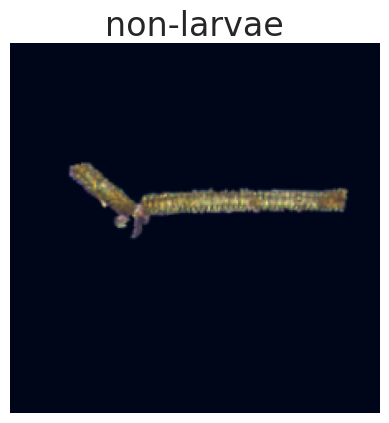

In [7]:
visualize_larvae_sample(train_loader.dataset)

In [8]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(798, 320, 480)

## 3. Training

### 3.1. Criterion

Since larvae data is unbalanced, we will use cross entropy with weights.

In [9]:
from torch import Tensor

N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)

optim_config = {
    "scheduler": "onecycle",
    "max_lr": 2e-4,
    "lr": 1e-4,
    "eta_min": 1e-6,
    "weight_decay": 1e-4,
    "warmup_epochs": 5,
}

# criterion = nn.CrossEntropyLoss()

### 3.2. CNN0

In [10]:
cnn_0 = HomogeneousCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="residual",
    device=device,
)
summary(cnn_0, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 224, 224]              84
       BatchNorm2d-2          [-1, 3, 224, 224]               6
              ReLU-3          [-1, 3, 224, 224]               0
            Conv2d-4         [-1, 16, 224, 224]             448
       BatchNorm2d-5         [-1, 16, 224, 224]              32
              ReLU-6         [-1, 16, 224, 224]               0
     ResidualBlock-7         [-1, 16, 224, 224]               0
         MaxPool2d-8         [-1, 16, 112, 112]               0
            Conv2d-9         [-1, 16, 112, 112]           2,320
      BatchNorm2d-10         [-1, 16, 112, 112]              32
             ReLU-11         [-1, 16, 112, 112]               0
           Conv2d-12         [-1, 32, 112, 112]           4,640
      BatchNorm2d-13         [-1, 32, 112, 112]              64
             ReLU-14         [-1, 32, 1

In [11]:
optimizer_cnn_0, scheduler_cnn_0 = build_optimizer_and_scheduler(
    cnn_0,
    optim_config,
    train_loader_len=len(train_loader),
    total_epochs=100,
)
ckpt_cnn_0 = "weights/larvae-adv-cnn-0.pt"
trainer_cnn_0 = Trainer(
    model=cnn_0,
    optimizer=optimizer_cnn_0,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_0,
    checkpoint_path=ckpt_cnn_0,
    patience=10,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [12]:
trainer_cnn_0.fit(train_loader, valid_loader, num_epochs=100)

📘 Epoch 1 | Train Loss: 0.6957 | Val Loss: 0.6731 | Train cohen_kappa_fn: 0.1429 | Val cohen_kappa_fn: 0.1167 | Train f1_fn: 0.7683 | Val f1_fn: 0.8072
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6516 | Val Loss: 0.6412 | Train cohen_kappa_fn: 0.1293 | Val cohen_kappa_fn: 0.2133 | Train f1_fn: 0.5929 | Val f1_fn: 0.7244
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6216 | Val Loss: 0.6142 | Train cohen_kappa_fn: 0.2531 | Val cohen_kappa_fn: 0.2774 | Train f1_fn: 0.8023 | Val f1_fn: 0.8982
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5829 | Val Loss: 0.6120 | Train cohen_kappa_fn: 0.2926 | Val cohen_kappa_fn: 0.3327 | Train f1_fn: 0.8607 | Val f1_fn: 0.9244
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5344 | Val Loss: 0.5169 | Train cohen_kappa_fn: 0.1799 | Val cohen_kappa_fn: 0.4208 | Train f1_fn: 0.6537 | Val f1_fn: 0.8725
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5511 | Val Loss: 0.5057 | Train cohen_kappa_fn: 0.2783 | Val cohen_kappa_fn: 0.4818 | Train f1_fn: 0.7699 | Val f1_fn: 0.9091
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4811 | Val Loss: 0.4706 | Train cohen_kappa_fn: 0.2127 | Val cohen_kappa_fn: 0.3464 | Train f1_fn: 0.6641 | Val f1_fn: 0.7991
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.4449 | Val Loss: 0.4491 | Train cohen_kappa_fn: 0.2908 | Val cohen_kappa_fn: 0.3728 | Train f1_fn: 0.7379 | Val f1_fn: 0.8018
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4039 | Val Loss: 0.4100 | Train cohen_kappa_fn: 0.2745 | Val cohen_kappa_fn: 0.3234 | Train f1_fn: 0.7136 | Val f1_fn: 0.7597
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.3671 | Val Loss: 0.3397 | Train cohen_kappa_fn: 0.6059 | Val cohen_kappa_fn: 0.7535 | Train f1_fn: 0.9191 | Val f1_fn: 0.9564
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.3079 | Val Loss: 0.3065 | Train cohen_kappa_fn: 0.5582 | Val cohen_kappa_fn: 0.5399 | Train f1_fn: 0.8961 | Val f1_fn: 0.8902
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.2819 | Val Loss: 0.2942 | Train cohen_kappa_fn: 0.7466 | Val cohen_kappa_fn: 0.7900 | Train f1_fn: 0.9589 | Val f1_fn: 0.9688
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.2500 | Val Loss: 0.3478 | Train cohen_kappa_fn: 0.7897 | Val cohen_kappa_fn: 0.7898 | Train f1_fn: 0.9701 | Val f1_fn: 0.9710
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.2168 | Val Loss: 0.2177 | Train cohen_kappa_fn: 0.7837 | Val cohen_kappa_fn: 0.8064 | Train f1_fn: 0.9639 | Val f1_fn: 0.9682
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.2114 | Val Loss: 0.2050 | Train cohen_kappa_fn: 0.8077 | Val cohen_kappa_fn: 0.7775 | Train f1_fn: 0.9667 | Val f1_fn: 0.9624
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.1794 | Val Loss: 0.2486 | Train cohen_kappa_fn: 0.8030 | Val cohen_kappa_fn: 0.8285 | Train f1_fn: 0.9669 | Val f1_fn: 0.9743
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1781 | Val Loss: 0.2103 | Train cohen_kappa_fn: 0.7308 | Val cohen_kappa_fn: 0.6645 | Train f1_fn: 0.9481 | Val f1_fn: 0.9315
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1461 | Val Loss: 0.1958 | Train cohen_kappa_fn: 0.7611 | Val cohen_kappa_fn: 0.7026 | Train f1_fn: 0.9573 | Val f1_fn: 0.9419
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.1521 | Val Loss: 0.3057 | Train cohen_kappa_fn: 0.5277 | Val cohen_kappa_fn: 0.5010 | Train f1_fn: 0.8799 | Val f1_fn: 0.8714
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1711 | Val Loss: 0.2436 | Train cohen_kappa_fn: 0.6393 | Val cohen_kappa_fn: 0.5740 | Train f1_fn: 0.9200 | Val f1_fn: 0.8984
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1821 | Val Loss: 0.1837 | Train cohen_kappa_fn: 0.8283 | Val cohen_kappa_fn: 0.7808 | Train f1_fn: 0.9696 | Val f1_fn: 0.9623
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.1393 | Val Loss: 0.2079 | Train cohen_kappa_fn: 0.8487 | Val cohen_kappa_fn: 0.8265 | Train f1_fn: 0.9744 | Val f1_fn: 0.9721
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1236 | Val Loss: 0.4176 | Train cohen_kappa_fn: 0.8690 | Val cohen_kappa_fn: 0.7661 | Train f1_fn: 0.9809 | Val f1_fn: 0.9695
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.1089 | Val Loss: 0.2029 | Train cohen_kappa_fn: 0.6917 | Val cohen_kappa_fn: 0.6199 | Train f1_fn: 0.9363 | Val f1_fn: 0.9163
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.1657 | Val Loss: 0.4896 | Train cohen_kappa_fn: 0.8125 | Val cohen_kappa_fn: 0.7500 | Train f1_fn: 0.9747 | Val f1_fn: 0.9677
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.1079 | Val Loss: 0.2265 | Train cohen_kappa_fn: 0.8750 | Val cohen_kappa_fn: 0.8617 | Train f1_fn: 0.9807 | Val f1_fn: 0.9799
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.1182 | Val Loss: 0.5296 | Train cohen_kappa_fn: 0.3555 | Val cohen_kappa_fn: 0.3259 | Train f1_fn: 0.7816 | Val f1_fn: 0.7558
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.1331 | Val Loss: 0.3891 | Train cohen_kappa_fn: 0.4007 | Val cohen_kappa_fn: 0.4310 | Train f1_fn: 0.8127 | Val f1_fn: 0.8408
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.1371 | Val Loss: 0.1466 | Train cohen_kappa_fn: 0.7845 | Val cohen_kappa_fn: 0.8123 | Train f1_fn: 0.9601 | Val f1_fn: 0.9680
  🔥 New best model saved!


📘 Epoch 30 | Train Loss: 0.1191 | Val Loss: 0.2202 | Train cohen_kappa_fn: 0.6286 | Val cohen_kappa_fn: 0.6246 | Train f1_fn: 0.9165 | Val f1_fn: 0.9160
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.0849 | Val Loss: 0.1597 | Train cohen_kappa_fn: 0.8713 | Val cohen_kappa_fn: 0.8123 | Train f1_fn: 0.9781 | Val f1_fn: 0.9680
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.0797 | Val Loss: 0.5515 | Train cohen_kappa_fn: 0.8111 | Val cohen_kappa_fn: 0.7336 | Train f1_fn: 0.9747 | Val f1_fn: 0.9660
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.1136 | Val Loss: 0.4381 | Train cohen_kappa_fn: 0.9039 | Val cohen_kappa_fn: 0.7746 | Train f1_fn: 0.9852 | Val f1_fn: 0.9693
  ❄️ No improvement, model won't be saved!


📘 Epoch 34 | Train Loss: 0.0933 | Val Loss: 0.2416 | Train cohen_kappa_fn: 0.6475 | Val cohen_kappa_fn: 0.6151 | Train f1_fn: 0.9226 | Val f1_fn: 0.9167
  ❄️ No improvement, model won't be saved!


📘 Epoch 35 | Train Loss: 0.0889 | Val Loss: 0.1725 | Train cohen_kappa_fn: 0.8047 | Val cohen_kappa_fn: 0.7606 | Train f1_fn: 0.9639 | Val f1_fn: 0.9560
  ❄️ No improvement, model won't be saved!


📘 Epoch 36 | Train Loss: 0.1146 | Val Loss: 0.2877 | Train cohen_kappa_fn: 0.9082 | Val cohen_kappa_fn: 0.8313 | Train f1_fn: 0.9850 | Val f1_fn: 0.9742
  ❄️ No improvement, model won't be saved!


📘 Epoch 37 | Train Loss: 0.1465 | Val Loss: 0.1949 | Train cohen_kappa_fn: 0.8505 | Val cohen_kappa_fn: 0.7775 | Train f1_fn: 0.9743 | Val f1_fn: 0.9624
  ❄️ No improvement, model won't be saved!


📘 Epoch 38 | Train Loss: 0.1308 | Val Loss: 0.2487 | Train cohen_kappa_fn: 0.9296 | Val cohen_kappa_fn: 0.8505 | Train f1_fn: 0.9888 | Val f1_fn: 0.9780
  ❄️ No improvement, model won't be saved!


📘 Epoch 39 | Train Loss: 0.1050 | Val Loss: 1.6607 | Train cohen_kappa_fn: 0.0728 | Val cohen_kappa_fn: 0.0836 | Train f1_fn: 0.3374 | Val f1_fn: 0.3686
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


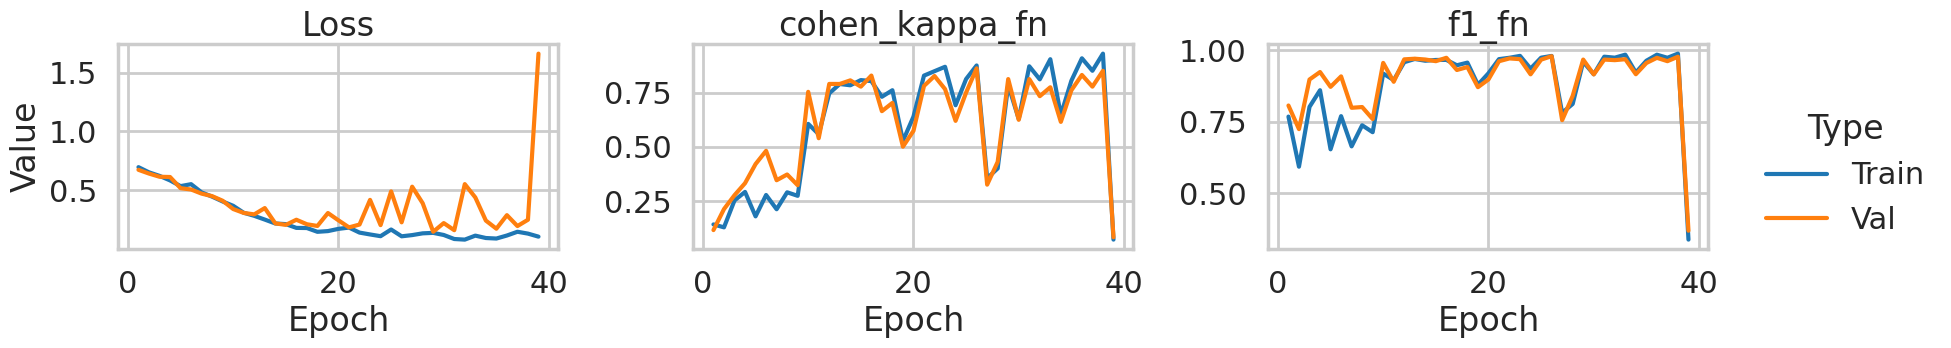

In [13]:
trainer_cnn_0.plot_epochs()

In [14]:
trainer_cnn_0.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1933 | Test cohen_kappa_fn: 0.7651 | Test f1_fn: 0.9598


#### Visualization

In [15]:
visualizer_0 = Visualizer(model=trainer_cnn_0.model, device=device, labels_map=labels_map)

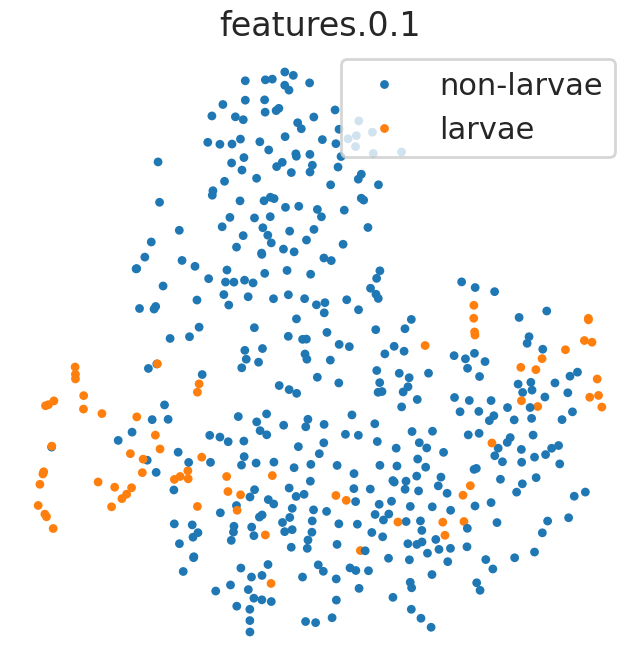

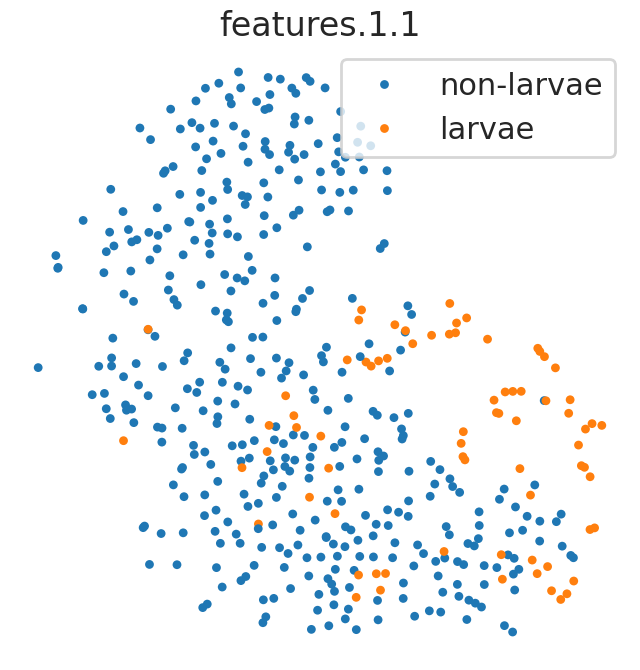

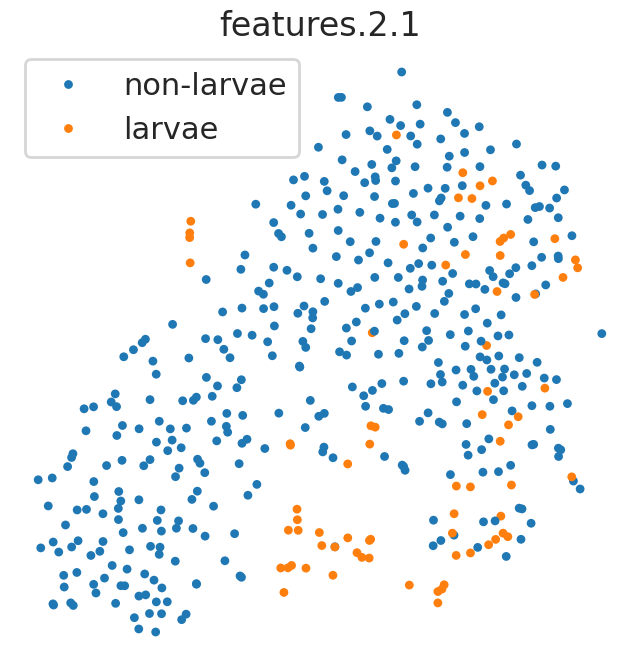

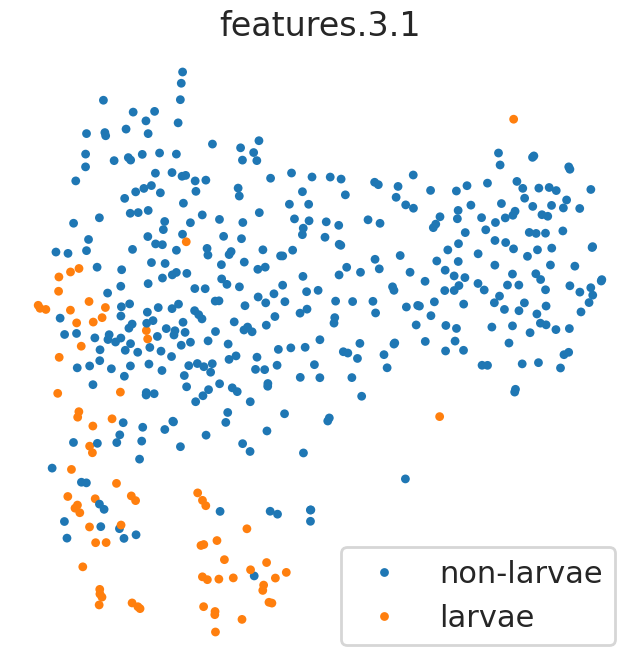

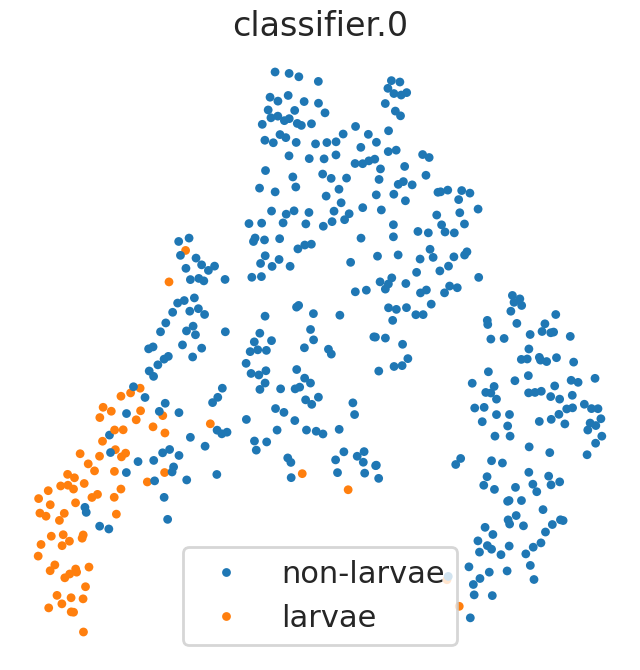

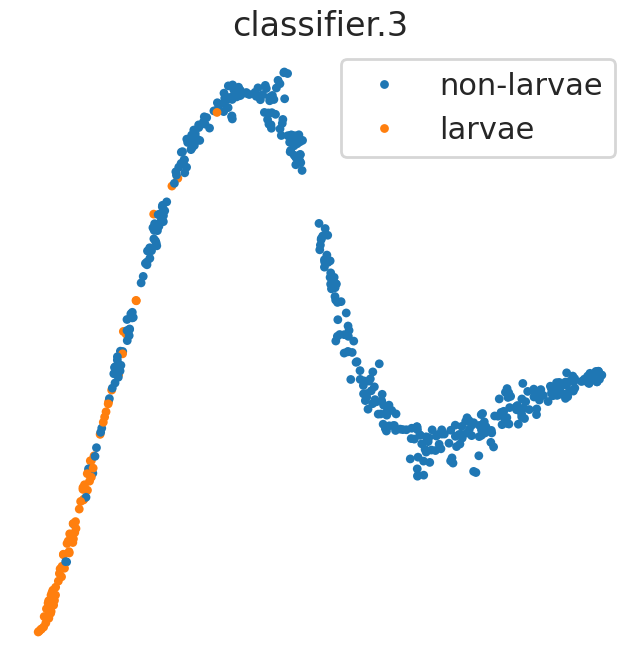

In [16]:
# Display layer representations
visualizer_0.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


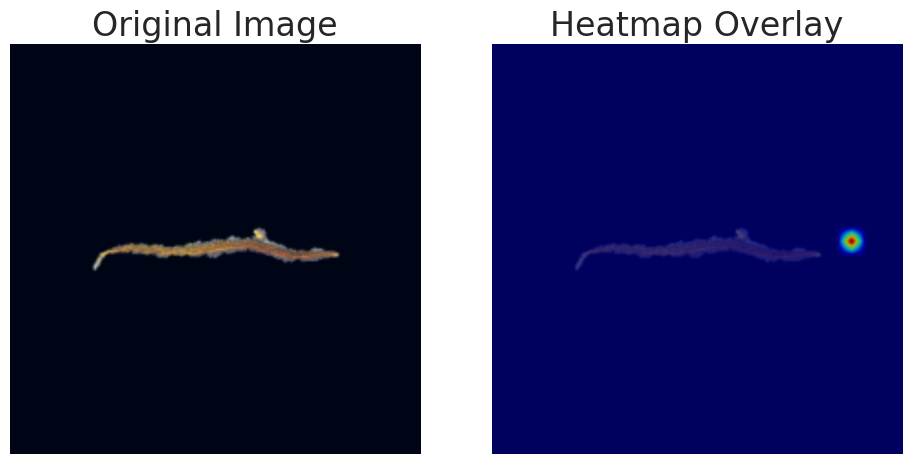

  Generating heatmap for Larvae...
  Predicted label is Non-larvae!


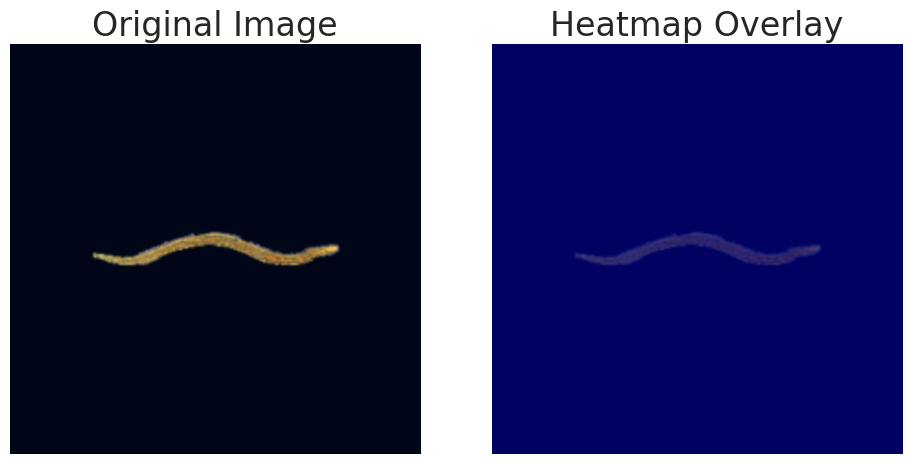

In [17]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.3. CNN1

In [18]:
cnn_1 = HomogeneousCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="inception",
    device=device,
)
summary(cnn_1, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 224, 224]              16
            Conv2d-2          [-1, 4, 224, 224]              16
            Conv2d-3          [-1, 4, 224, 224]             148
            Conv2d-4          [-1, 4, 224, 224]              16
            Conv2d-5          [-1, 4, 224, 224]             404
         MaxPool2d-6          [-1, 3, 224, 224]               0
            Conv2d-7          [-1, 4, 224, 224]              16
       BatchNorm2d-8         [-1, 16, 224, 224]              32
    InceptionBlock-9         [-1, 16, 224, 224]               0
        MaxPool2d-10         [-1, 16, 112, 112]               0
           Conv2d-11          [-1, 8, 112, 112]             136
           Conv2d-12          [-1, 8, 112, 112]             136
           Conv2d-13          [-1, 8, 112, 112]             584
           Conv2d-14          [-1, 8, 1

In [19]:
optimizer_cnn_1, scheduler_cnn_1 = build_optimizer_and_scheduler(
    cnn_1,
    optim_config,
    train_loader_len=len(train_loader),
    total_epochs=100,
)
ckpt_cnn_1 = "weights/larvae-adv-cnn-1.pt"
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=10,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [20]:
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=100)

📘 Epoch 1 | Train Loss: 0.6748 | Val Loss: 0.6659 | Train cohen_kappa_fn: 0.0591 | Val cohen_kappa_fn: 0.0633 | Train f1_fn: 0.2994 | Val f1_fn: 0.3019
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6164 | Val Loss: 0.6912 | Train cohen_kappa_fn: 0.0302 | Val cohen_kappa_fn: 0.0501 | Train f1_fn: 0.1682 | Val f1_fn: 0.2524
  ❄️ No improvement, model won't be saved!


📘 Epoch 3 | Train Loss: 0.5619 | Val Loss: 0.5663 | Train cohen_kappa_fn: 0.1879 | Val cohen_kappa_fn: 0.1573 | Train f1_fn: 0.6436 | Val f1_fn: 0.6406
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5411 | Val Loss: 0.5587 | Train cohen_kappa_fn: 0.1221 | Val cohen_kappa_fn: 0.1217 | Train f1_fn: 0.4809 | Val f1_fn: 0.4860
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5046 | Val Loss: 0.5158 | Train cohen_kappa_fn: 0.2909 | Val cohen_kappa_fn: 0.3500 | Train f1_fn: 0.7771 | Val f1_fn: 0.8260
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.4855 | Val Loss: 0.4931 | Train cohen_kappa_fn: 0.2532 | Val cohen_kappa_fn: 0.2398 | Train f1_fn: 0.6974 | Val f1_fn: 0.6860
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4503 | Val Loss: 0.4787 | Train cohen_kappa_fn: 0.4107 | Val cohen_kappa_fn: 0.4140 | Train f1_fn: 0.8454 | Val f1_fn: 0.8512
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.4574 | Val Loss: 0.4589 | Train cohen_kappa_fn: 0.3627 | Val cohen_kappa_fn: 0.3650 | Train f1_fn: 0.8052 | Val f1_fn: 0.7965
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4150 | Val Loss: 0.4458 | Train cohen_kappa_fn: 0.3124 | Val cohen_kappa_fn: 0.2599 | Train f1_fn: 0.7618 | Val f1_fn: 0.7078
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.4110 | Val Loss: 0.4198 | Train cohen_kappa_fn: 0.5012 | Val cohen_kappa_fn: 0.4219 | Train f1_fn: 0.8778 | Val f1_fn: 0.8358
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.3655 | Val Loss: 0.4209 | Train cohen_kappa_fn: 0.4253 | Val cohen_kappa_fn: 0.3200 | Train f1_fn: 0.8451 | Val f1_fn: 0.7569
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.3885 | Val Loss: 0.4560 | Train cohen_kappa_fn: 0.3798 | Val cohen_kappa_fn: 0.2147 | Train f1_fn: 0.8067 | Val f1_fn: 0.6364
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.3360 | Val Loss: 0.3934 | Train cohen_kappa_fn: 0.5145 | Val cohen_kappa_fn: 0.3595 | Train f1_fn: 0.8844 | Val f1_fn: 0.7875
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.3429 | Val Loss: 0.4098 | Train cohen_kappa_fn: 0.4157 | Val cohen_kappa_fn: 0.2873 | Train f1_fn: 0.8270 | Val f1_fn: 0.7277
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.3092 | Val Loss: 0.3387 | Train cohen_kappa_fn: 0.5561 | Val cohen_kappa_fn: 0.4954 | Train f1_fn: 0.8963 | Val f1_fn: 0.8719
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.2857 | Val Loss: 0.3621 | Train cohen_kappa_fn: 0.4719 | Val cohen_kappa_fn: 0.3709 | Train f1_fn: 0.8542 | Val f1_fn: 0.7956
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.3004 | Val Loss: 0.3249 | Train cohen_kappa_fn: 0.5943 | Val cohen_kappa_fn: 0.5057 | Train f1_fn: 0.9073 | Val f1_fn: 0.8848
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.2651 | Val Loss: 0.3154 | Train cohen_kappa_fn: 0.5791 | Val cohen_kappa_fn: 0.5235 | Train f1_fn: 0.9063 | Val f1_fn: 0.8968
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.2645 | Val Loss: 0.3091 | Train cohen_kappa_fn: 0.7481 | Val cohen_kappa_fn: 0.6748 | Train f1_fn: 0.9560 | Val f1_fn: 0.9456
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.2824 | Val Loss: 0.3573 | Train cohen_kappa_fn: 0.4752 | Val cohen_kappa_fn: 0.3768 | Train f1_fn: 0.8586 | Val f1_fn: 0.8044
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.2696 | Val Loss: 0.3583 | Train cohen_kappa_fn: 0.5255 | Val cohen_kappa_fn: 0.3973 | Train f1_fn: 0.8801 | Val f1_fn: 0.8174
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.2470 | Val Loss: 0.2855 | Train cohen_kappa_fn: 0.7265 | Val cohen_kappa_fn: 0.6435 | Train f1_fn: 0.9493 | Val f1_fn: 0.9351
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.2231 | Val Loss: 0.2925 | Train cohen_kappa_fn: 0.7915 | Val cohen_kappa_fn: 0.6279 | Train f1_fn: 0.9636 | Val f1_fn: 0.9310
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.2543 | Val Loss: 0.3554 | Train cohen_kappa_fn: 0.5576 | Val cohen_kappa_fn: 0.4032 | Train f1_fn: 0.8940 | Val f1_fn: 0.8166
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.2346 | Val Loss: 0.3126 | Train cohen_kappa_fn: 0.8175 | Val cohen_kappa_fn: 0.7491 | Train f1_fn: 0.9700 | Val f1_fn: 0.9612
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.2341 | Val Loss: 0.2815 | Train cohen_kappa_fn: 0.8077 | Val cohen_kappa_fn: 0.6925 | Train f1_fn: 0.9667 | Val f1_fn: 0.9495
  🔥 New best model saved!


📘 Epoch 27 | Train Loss: 0.1969 | Val Loss: 0.2757 | Train cohen_kappa_fn: 0.7445 | Val cohen_kappa_fn: 0.7201 | Train f1_fn: 0.9523 | Val f1_fn: 0.9554
  🔥 New best model saved!


📘 Epoch 28 | Train Loss: 0.2045 | Val Loss: 0.2323 | Train cohen_kappa_fn: 0.7211 | Val cohen_kappa_fn: 0.7288 | Train f1_fn: 0.9457 | Val f1_fn: 0.9551
  🔥 New best model saved!


📘 Epoch 29 | Train Loss: 0.1818 | Val Loss: 0.2538 | Train cohen_kappa_fn: 0.7915 | Val cohen_kappa_fn: 0.7590 | Train f1_fn: 0.9636 | Val f1_fn: 0.9631
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.1704 | Val Loss: 0.2396 | Train cohen_kappa_fn: 0.8100 | Val cohen_kappa_fn: 0.7491 | Train f1_fn: 0.9666 | Val f1_fn: 0.9612
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.1828 | Val Loss: 0.2352 | Train cohen_kappa_fn: 0.6467 | Val cohen_kappa_fn: 0.6751 | Train f1_fn: 0.9237 | Val f1_fn: 0.9359
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.1690 | Val Loss: 0.2384 | Train cohen_kappa_fn: 0.7736 | Val cohen_kappa_fn: 0.7740 | Train f1_fn: 0.9587 | Val f1_fn: 0.9625
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.1654 | Val Loss: 0.2455 | Train cohen_kappa_fn: 0.6513 | Val cohen_kappa_fn: 0.6240 | Train f1_fn: 0.9244 | Val f1_fn: 0.9213
  ❄️ No improvement, model won't be saved!


📘 Epoch 34 | Train Loss: 0.1493 | Val Loss: 0.2411 | Train cohen_kappa_fn: 0.6357 | Val cohen_kappa_fn: 0.6151 | Train f1_fn: 0.9203 | Val f1_fn: 0.9167
  ❄️ No improvement, model won't be saved!


📘 Epoch 35 | Train Loss: 0.1486 | Val Loss: 0.3228 | Train cohen_kappa_fn: 0.8681 | Val cohen_kappa_fn: 0.7900 | Train f1_fn: 0.9792 | Val f1_fn: 0.9688
  ❄️ No improvement, model won't be saved!


📘 Epoch 36 | Train Loss: 0.1663 | Val Loss: 0.2320 | Train cohen_kappa_fn: 0.7576 | Val cohen_kappa_fn: 0.7460 | Train f1_fn: 0.9546 | Val f1_fn: 0.9567
  🔥 New best model saved!


📘 Epoch 37 | Train Loss: 0.1294 | Val Loss: 0.2349 | Train cohen_kappa_fn: 0.8567 | Val cohen_kappa_fn: 0.7766 | Train f1_fn: 0.9759 | Val f1_fn: 0.9647
  ❄️ No improvement, model won't be saved!


📘 Epoch 38 | Train Loss: 0.1103 | Val Loss: 0.3163 | Train cohen_kappa_fn: 0.8715 | Val cohen_kappa_fn: 0.8006 | Train f1_fn: 0.9800 | Val f1_fn: 0.9707
  ❄️ No improvement, model won't be saved!


📘 Epoch 39 | Train Loss: 0.1675 | Val Loss: 0.2604 | Train cohen_kappa_fn: 0.6241 | Val cohen_kappa_fn: 0.6310 | Train f1_fn: 0.9158 | Val f1_fn: 0.9234
  ❄️ No improvement, model won't be saved!


📘 Epoch 40 | Train Loss: 0.2172 | Val Loss: 0.2482 | Train cohen_kappa_fn: 0.6136 | Val cohen_kappa_fn: 0.6002 | Train f1_fn: 0.9123 | Val f1_fn: 0.9098
  ❄️ No improvement, model won't be saved!


📘 Epoch 41 | Train Loss: 0.1910 | Val Loss: 0.2121 | Train cohen_kappa_fn: 0.7100 | Val cohen_kappa_fn: 0.6719 | Train f1_fn: 0.9413 | Val f1_fn: 0.9336
  🔥 New best model saved!


📘 Epoch 42 | Train Loss: 0.1579 | Val Loss: 0.5358 | Train cohen_kappa_fn: 0.8456 | Val cohen_kappa_fn: 0.7165 | Train f1_fn: 0.9781 | Val f1_fn: 0.9622
  ❄️ No improvement, model won't be saved!


📘 Epoch 43 | Train Loss: 0.2227 | Val Loss: 0.2302 | Train cohen_kappa_fn: 0.7623 | Val cohen_kappa_fn: 0.7321 | Train f1_fn: 0.9553 | Val f1_fn: 0.9526
  ❄️ No improvement, model won't be saved!


📘 Epoch 44 | Train Loss: 0.1258 | Val Loss: 0.2900 | Train cohen_kappa_fn: 0.8898 | Val cohen_kappa_fn: 0.7795 | Train f1_fn: 0.9820 | Val f1_fn: 0.9669
  ❄️ No improvement, model won't be saved!


📘 Epoch 45 | Train Loss: 0.1186 | Val Loss: 0.3356 | Train cohen_kappa_fn: 0.9196 | Val cohen_kappa_fn: 0.7692 | Train f1_fn: 0.9874 | Val f1_fn: 0.9650
  ❄️ No improvement, model won't be saved!


📘 Epoch 46 | Train Loss: 0.1055 | Val Loss: 0.2946 | Train cohen_kappa_fn: 0.8746 | Val cohen_kappa_fn: 0.7692 | Train f1_fn: 0.9789 | Val f1_fn: 0.9650
  ❄️ No improvement, model won't be saved!


📘 Epoch 47 | Train Loss: 0.1083 | Val Loss: 0.2749 | Train cohen_kappa_fn: 0.9076 | Val cohen_kappa_fn: 0.7831 | Train f1_fn: 0.9851 | Val f1_fn: 0.9668
  ❄️ No improvement, model won't be saved!


📘 Epoch 48 | Train Loss: 0.1158 | Val Loss: 0.2340 | Train cohen_kappa_fn: 0.8208 | Val cohen_kappa_fn: 0.7966 | Train f1_fn: 0.9680 | Val f1_fn: 0.9663
  ❄️ No improvement, model won't be saved!


📘 Epoch 49 | Train Loss: 0.0963 | Val Loss: 0.2847 | Train cohen_kappa_fn: 0.8898 | Val cohen_kappa_fn: 0.7831 | Train f1_fn: 0.9820 | Val f1_fn: 0.9668
  ❄️ No improvement, model won't be saved!


📘 Epoch 50 | Train Loss: 0.1036 | Val Loss: 0.7271 | Train cohen_kappa_fn: 0.8351 | Val cohen_kappa_fn: 0.6944 | Train f1_fn: 0.9775 | Val f1_fn: 0.9606
  ❄️ No improvement, model won't be saved!


📘 Epoch 51 | Train Loss: 0.0938 | Val Loss: 0.2096 | Train cohen_kappa_fn: 0.8436 | Val cohen_kappa_fn: 0.7802 | Train f1_fn: 0.9727 | Val f1_fn: 0.9646
  🔥 New best model saved!


📘 Epoch 52 | Train Loss: 0.1116 | Val Loss: 0.1880 | Train cohen_kappa_fn: 0.7718 | Val cohen_kappa_fn: 0.7625 | Train f1_fn: 0.9568 | Val f1_fn: 0.9583
  🔥 New best model saved!


📘 Epoch 53 | Train Loss: 0.1334 | Val Loss: 0.2350 | Train cohen_kappa_fn: 0.8554 | Val cohen_kappa_fn: 0.8001 | Train f1_fn: 0.9750 | Val f1_fn: 0.9685
  ❄️ No improvement, model won't be saved!


📘 Epoch 54 | Train Loss: 0.1161 | Val Loss: 0.4821 | Train cohen_kappa_fn: 0.9093 | Val cohen_kappa_fn: 0.7481 | Train f1_fn: 0.9868 | Val f1_fn: 0.9656
  ❄️ No improvement, model won't be saved!


📘 Epoch 55 | Train Loss: 0.1110 | Val Loss: 0.2648 | Train cohen_kappa_fn: 0.8208 | Val cohen_kappa_fn: 0.7831 | Train f1_fn: 0.9680 | Val f1_fn: 0.9668
  ❄️ No improvement, model won't be saved!


📘 Epoch 56 | Train Loss: 0.1308 | Val Loss: 0.2228 | Train cohen_kappa_fn: 0.7530 | Val cohen_kappa_fn: 0.7645 | Train f1_fn: 0.9519 | Val f1_fn: 0.9606
  ❄️ No improvement, model won't be saved!


📘 Epoch 57 | Train Loss: 0.1235 | Val Loss: 0.4800 | Train cohen_kappa_fn: 0.8450 | Val cohen_kappa_fn: 0.7508 | Train f1_fn: 0.9754 | Val f1_fn: 0.9634
  ❄️ No improvement, model won't be saved!


📘 Epoch 58 | Train Loss: 0.0896 | Val Loss: 0.2834 | Train cohen_kappa_fn: 0.8990 | Val cohen_kappa_fn: 0.8134 | Train f1_fn: 0.9835 | Val f1_fn: 0.9703
  ❄️ No improvement, model won't be saved!


📘 Epoch 59 | Train Loss: 0.0816 | Val Loss: 0.2220 | Train cohen_kappa_fn: 0.8256 | Val cohen_kappa_fn: 0.7321 | Train f1_fn: 0.9687 | Val f1_fn: 0.9526
  ❄️ No improvement, model won't be saved!


📘 Epoch 60 | Train Loss: 0.0943 | Val Loss: 0.2053 | Train cohen_kappa_fn: 0.8514 | Val cohen_kappa_fn: 0.7966 | Train f1_fn: 0.9742 | Val f1_fn: 0.9663
  ❄️ No improvement, model won't be saved!


📘 Epoch 61 | Train Loss: 0.0535 | Val Loss: 0.2754 | Train cohen_kappa_fn: 0.8602 | Val cohen_kappa_fn: 0.7867 | Train f1_fn: 0.9758 | Val f1_fn: 0.9667
  ❄️ No improvement, model won't be saved!


📘 Epoch 62 | Train Loss: 0.1058 | Val Loss: 0.3043 | Train cohen_kappa_fn: 0.5708 | Val cohen_kappa_fn: 0.5226 | Train f1_fn: 0.8962 | Val f1_fn: 0.8807
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


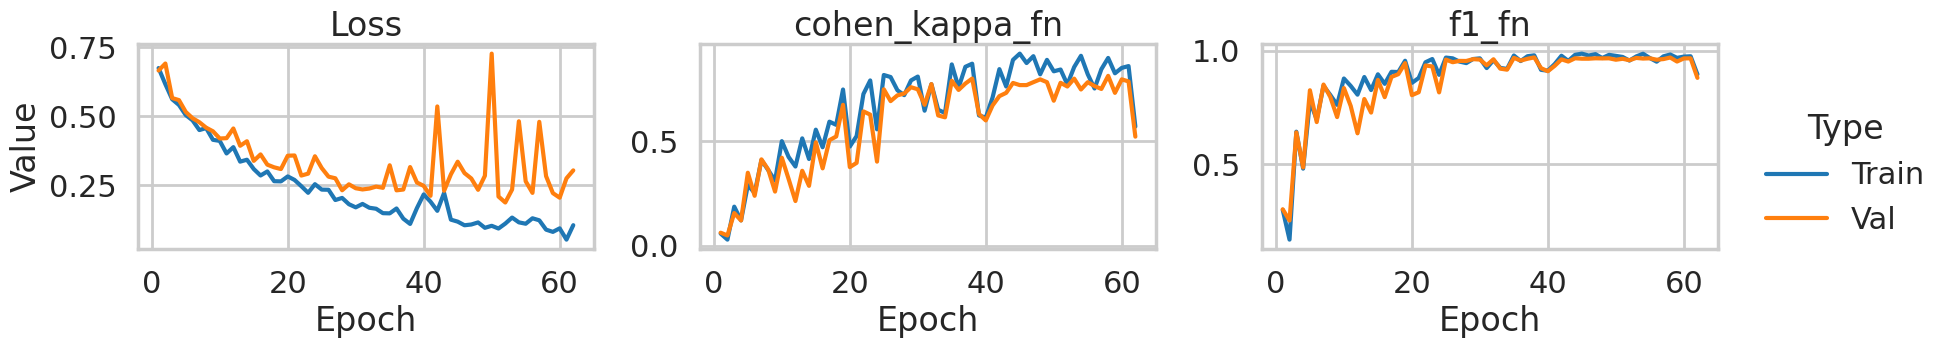

In [21]:
trainer_cnn_1.plot_epochs()

In [22]:
trainer_cnn_1.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1672 | Test cohen_kappa_fn: 0.7729 | Test f1_fn: 0.9626


#### Visualization

In [23]:
visualizer_1 = Visualizer(model=trainer_cnn_1.model, device=device, labels_map=labels_map)

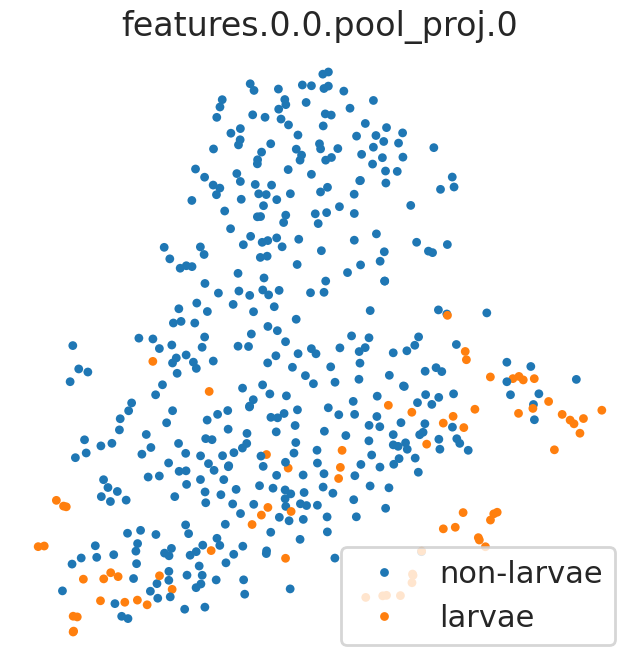

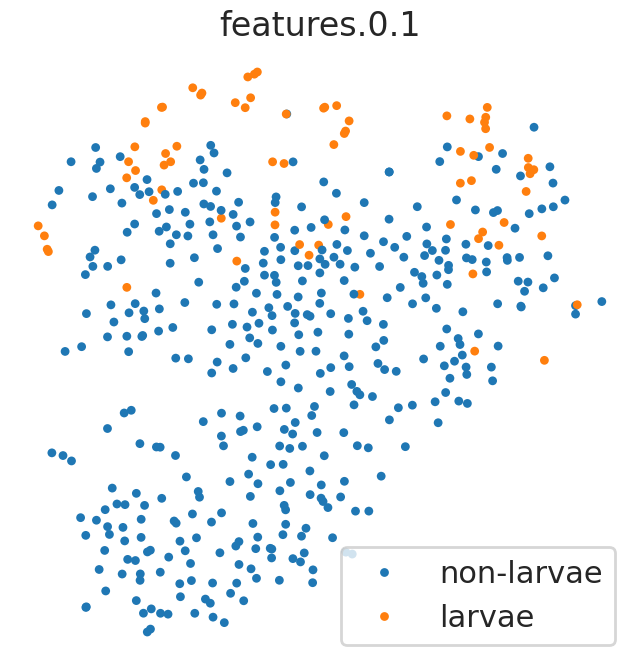

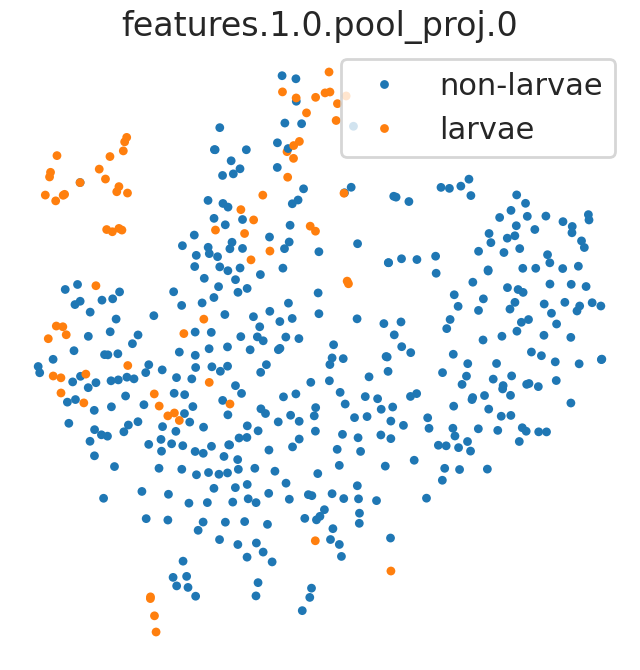

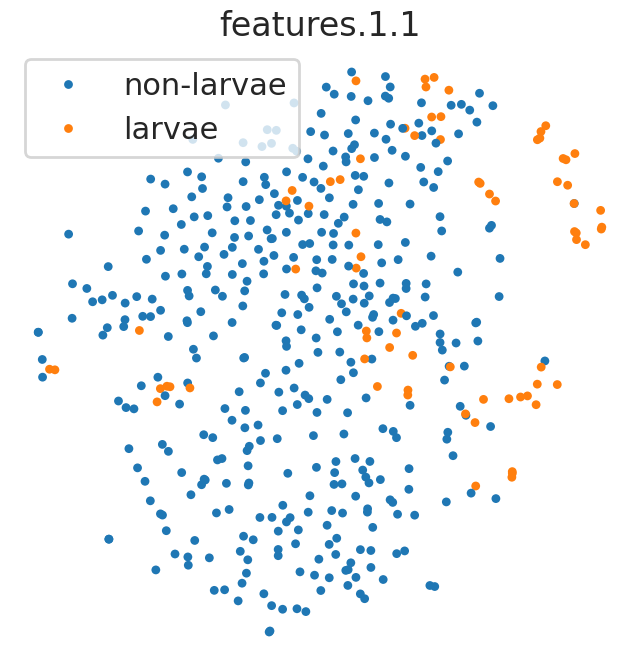

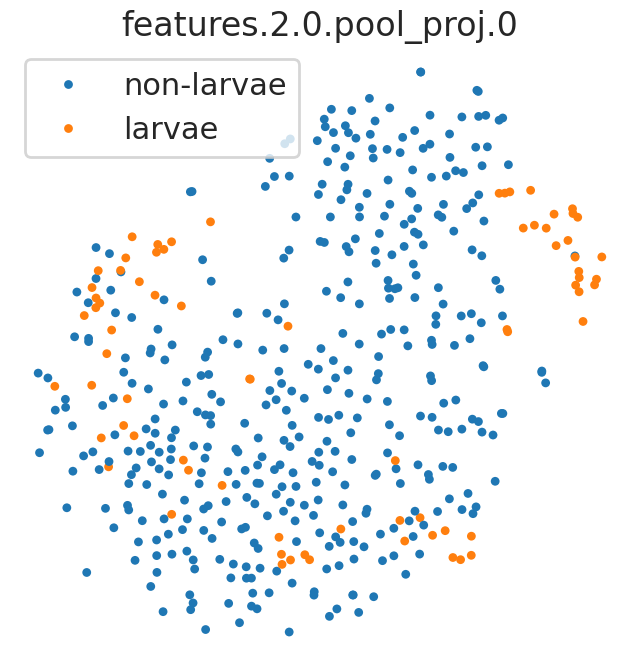

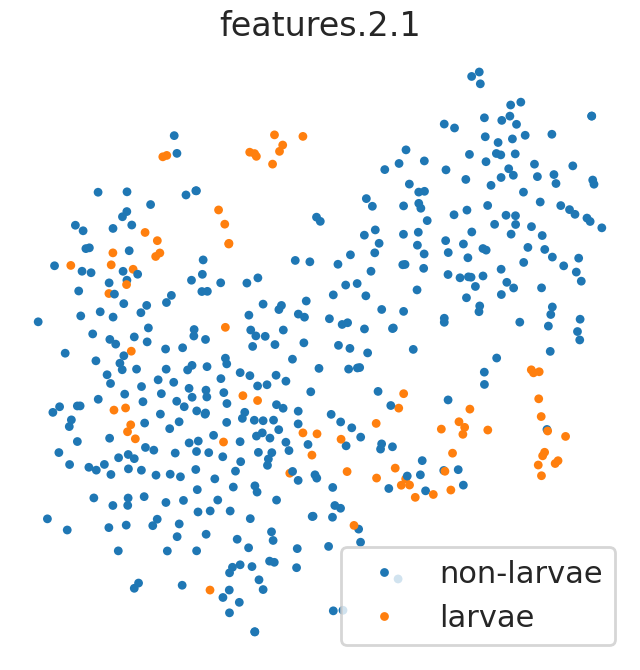

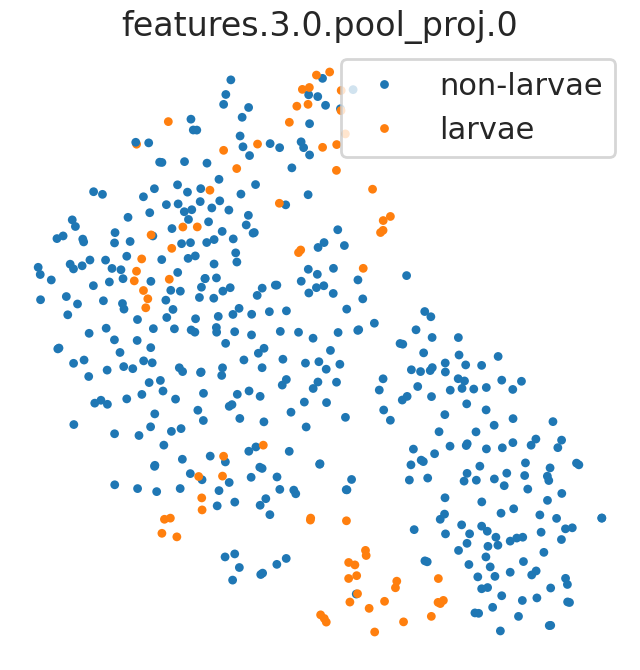

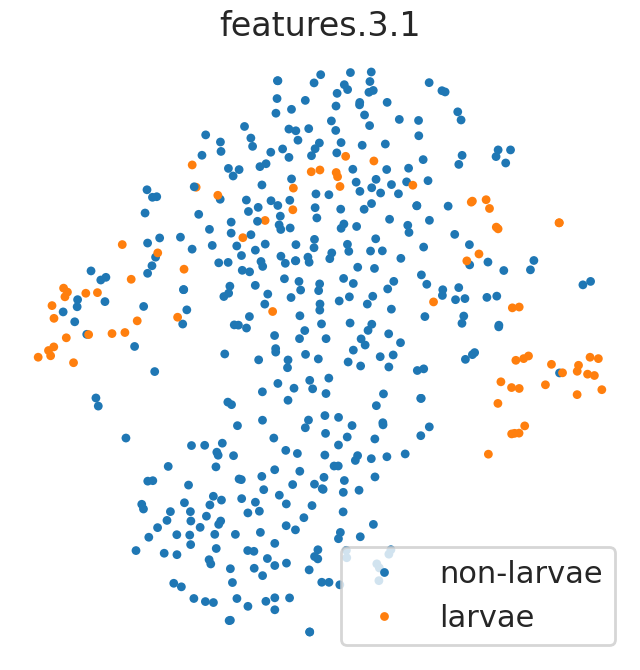

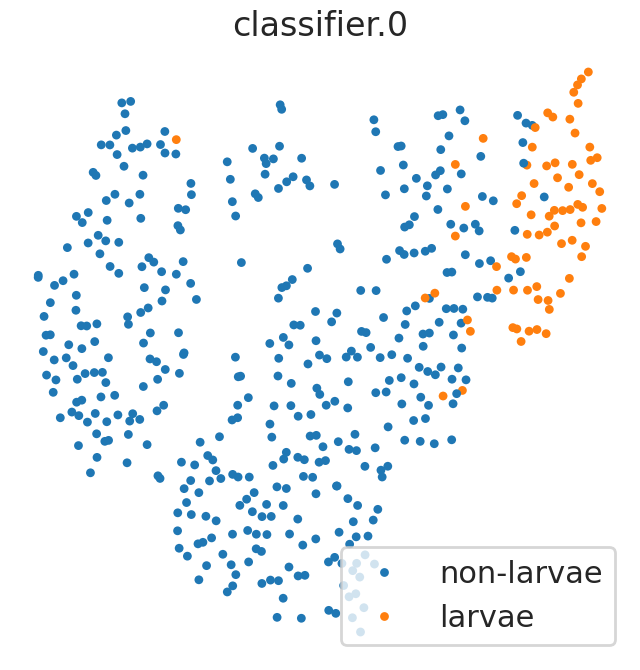

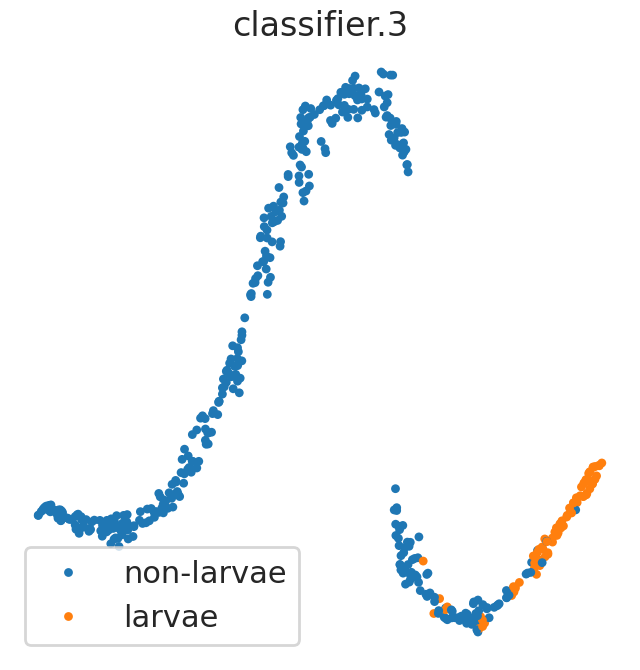

In [24]:
# Display layer representations
visualizer_1.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


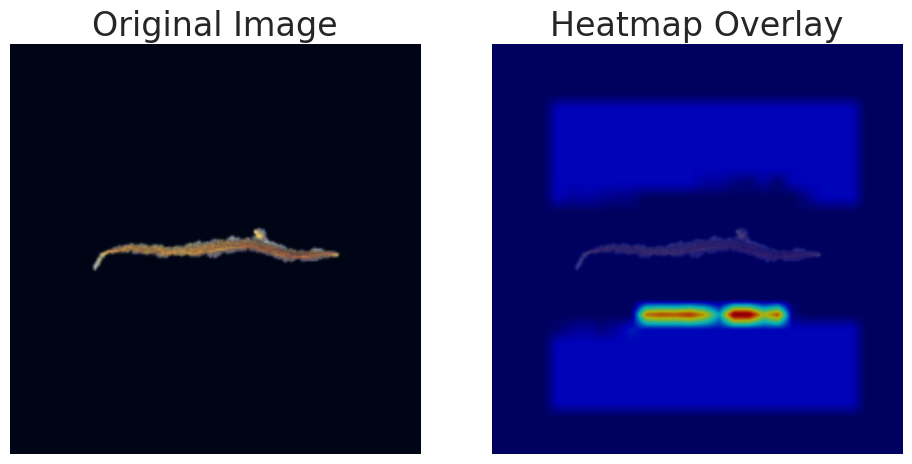

  Generating heatmap for Larvae...
  Predicted label is Non-larvae!


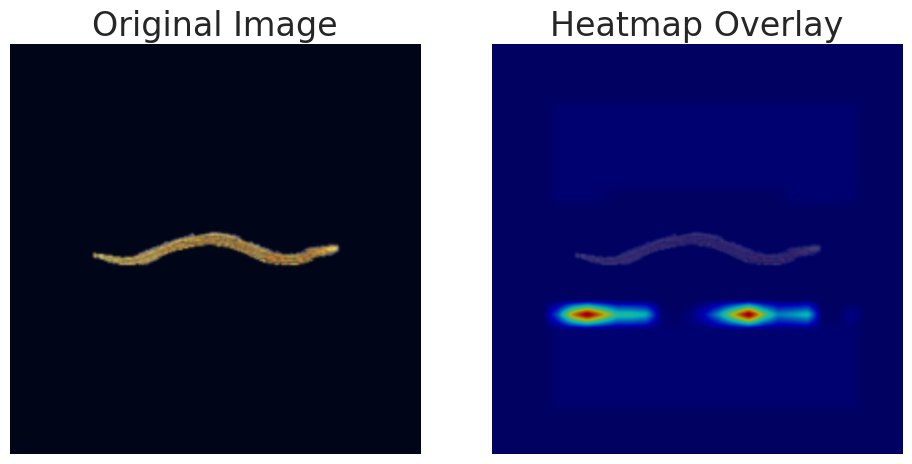

In [25]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.4. CNN2

In [26]:
cnn_2 = HomogeneousCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="se",
    device=device,
)
summary(cnn_2, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
            Conv2d-3         [-1, 16, 224, 224]             272
              ReLU-4         [-1, 16, 224, 224]               0
            Conv2d-5          [-1, 8, 224, 224]             136
              ReLU-6          [-1, 8, 224, 224]               0
            Conv2d-7          [-1, 8, 224, 224]           1,160
              ReLU-8          [-1, 8, 224, 224]               0
         FireBlock-9         [-1, 16, 224, 224]               0
        MaxPool2d-10         [-1, 16, 112, 112]               0
           Conv2d-11         [-1, 32, 112, 112]           4,640
             ReLU-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             528
             ReLU-14         [-1, 16, 1

In [27]:
optimizer_cnn_2, scheduler_cnn_2 = build_optimizer_and_scheduler(
    cnn_2,
    optim_config,
    train_loader_len=len(train_loader),
    total_epochs=100,
)
ckpt_cnn_2 = "weights/larvae-adv-cnn-2.pt"
trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=10,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [28]:
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=100)

📘 Epoch 1 | Train Loss: 0.6956 | Val Loss: 0.6911 | Train cohen_kappa_fn: 0.0878 | Val cohen_kappa_fn: 0.0600 | Train f1_fn: 0.4460 | Val f1_fn: 0.5132
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6905 | Val Loss: 0.6889 | Train cohen_kappa_fn: 0.0846 | Val cohen_kappa_fn: 0.0713 | Train f1_fn: 0.3991 | Val f1_fn: 0.4696
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6856 | Val Loss: 0.6857 | Train cohen_kappa_fn: 0.0222 | Val cohen_kappa_fn: -0.0652 | Train f1_fn: 0.7895 | Val f1_fn: 0.8218
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6790 | Val Loss: 0.6859 | Train cohen_kappa_fn: 0.0289 | Val cohen_kappa_fn: -0.0346 | Train f1_fn: 0.8957 | Val f1_fn: 0.9041
  ❄️ No improvement, model won't be saved!


📘 Epoch 5 | Train Loss: 0.6629 | Val Loss: 0.6773 | Train cohen_kappa_fn: 0.1511 | Val cohen_kappa_fn: 0.0052 | Train f1_fn: 0.6359 | Val f1_fn: 0.6048
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.6454 | Val Loss: 0.6941 | Train cohen_kappa_fn: 0.1255 | Val cohen_kappa_fn: 0.0105 | Train f1_fn: 0.6268 | Val f1_fn: 0.6294
  ❄️ No improvement, model won't be saved!


📘 Epoch 7 | Train Loss: 0.6168 | Val Loss: 0.6934 | Train cohen_kappa_fn: 0.1288 | Val cohen_kappa_fn: 0.0730 | Train f1_fn: 0.5318 | Val f1_fn: 0.5403
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.5948 | Val Loss: 0.8091 | Train cohen_kappa_fn: 0.1936 | Val cohen_kappa_fn: 0.0687 | Train f1_fn: 0.6899 | Val f1_fn: 0.7077
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.5842 | Val Loss: 0.7247 | Train cohen_kappa_fn: 0.1681 | Val cohen_kappa_fn: 0.1070 | Train f1_fn: 0.6061 | Val f1_fn: 0.6143
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.5628 | Val Loss: 0.8057 | Train cohen_kappa_fn: 0.2103 | Val cohen_kappa_fn: 0.1647 | Train f1_fn: 0.6907 | Val f1_fn: 0.7451
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.5596 | Val Loss: 0.8440 | Train cohen_kappa_fn: 0.1927 | Val cohen_kappa_fn: 0.2346 | Train f1_fn: 0.6660 | Val f1_fn: 0.7794
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.5479 | Val Loss: 0.7059 | Train cohen_kappa_fn: 0.1924 | Val cohen_kappa_fn: 0.2260 | Train f1_fn: 0.6374 | Val f1_fn: 0.7588
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.5446 | Val Loss: 0.7595 | Train cohen_kappa_fn: 0.3635 | Val cohen_kappa_fn: 0.3770 | Train f1_fn: 0.8305 | Val f1_fn: 0.9214
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.4854 | Val Loss: 0.9568 | Train cohen_kappa_fn: 0.3917 | Val cohen_kappa_fn: 0.2778 | Train f1_fn: 0.8439 | Val f1_fn: 0.9068
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.5073 | Val Loss: 0.6929 | Train cohen_kappa_fn: 0.2370 | Val cohen_kappa_fn: 0.3669 | Train f1_fn: 0.6860 | Val f1_fn: 0.8525
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


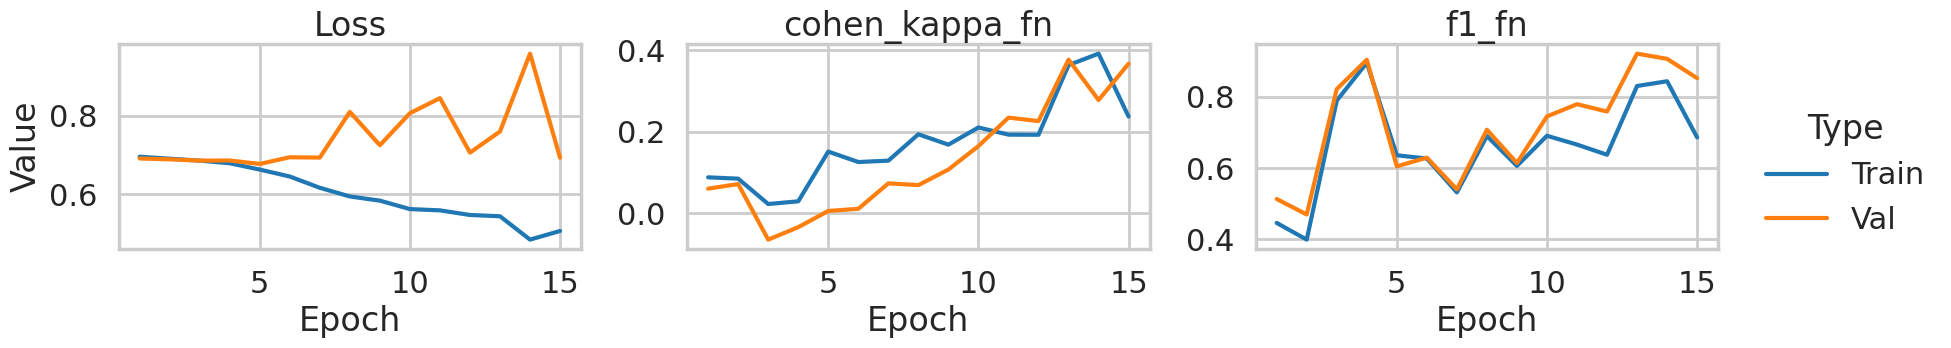

In [29]:
trainer_cnn_2.plot_epochs()

In [30]:
trainer_cnn_2.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.6473 | Test cohen_kappa_fn: 0.1069 | Test f1_fn: 0.6967


#### Visualization

In [31]:
visualizer_2 = Visualizer(model=trainer_cnn_2.model, device=device, labels_map=labels_map)

In [32]:
# Display layer representations
# visualizer_2.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


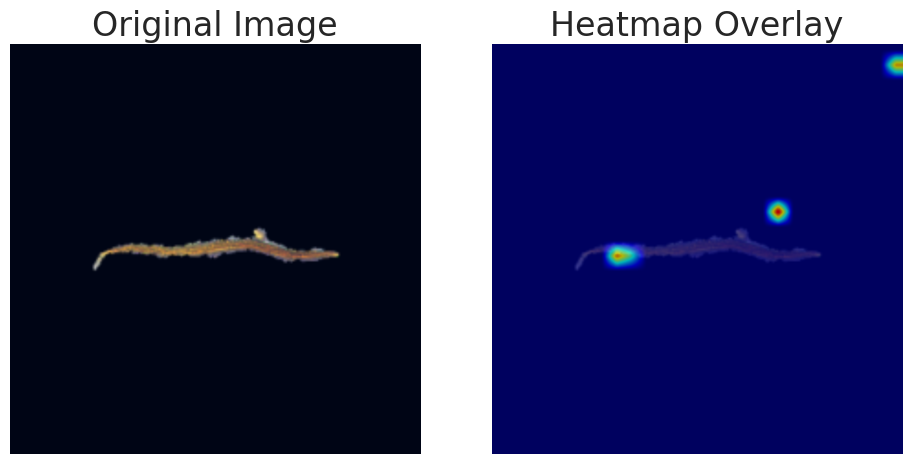

  Generating heatmap for Larvae...
  Predicted label is Larvae!


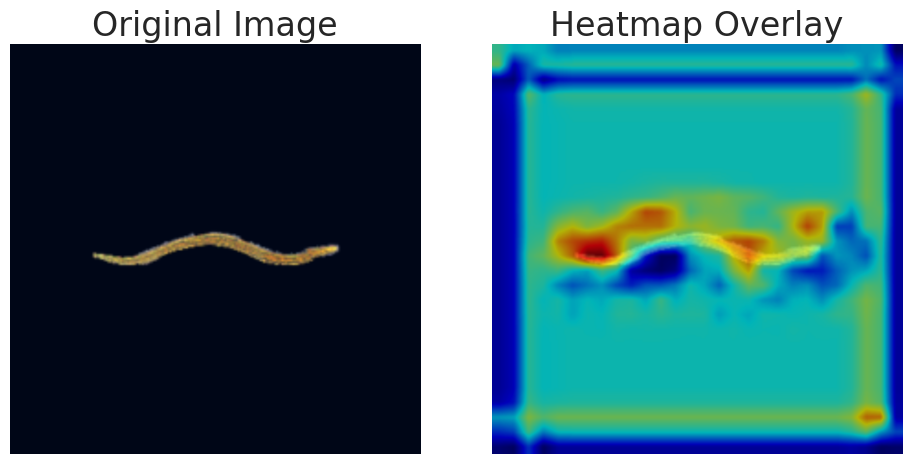

In [33]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.5. CNN3

In [34]:
cnn_3 = HomogeneousCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="cbam",
    device=device,
)
summary(cnn_3, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
 AdaptiveMaxPool2d-3             [-1, 16, 1, 1]               0
 AdaptiveAvgPool2d-4             [-1, 16, 1, 1]               0
            Conv2d-5              [-1, 1, 1, 1]              16
              ReLU-6              [-1, 1, 1, 1]               0
            Conv2d-7             [-1, 16, 1, 1]              16
            Conv2d-8              [-1, 1, 1, 1]              16
              ReLU-9              [-1, 1, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]              16
          Sigmoid-11             [-1, 16, 1, 1]               0
 ChannelAttention-12             [-1, 16, 1, 1]               0
           Conv2d-13          [-1, 1, 224, 224]              99
          Sigmoid-14          [-1, 1, 2

In [35]:
cbam_optim_config = {
    "scheduler": "onecycle",
    "max_lr": 1e-3,
    "lr": 3e-4,
    "eta_min": 5e-6,
    "weight_decay": 1e-4,
    "warmup_epochs": 5,
}
optimizer_cnn_3, scheduler_cnn_3 = build_optimizer_and_scheduler(
    cnn_3,
    cbam_optim_config,
    train_loader_len=len(train_loader),
    total_epochs=100,
)
ckpt_cnn_3 = "weights/larvae-adv-cnn-3.pt"
trainer_cnn_3 = Trainer(
    model=cnn_3,
    optimizer=optimizer_cnn_3,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_3,
    checkpoint_path=ckpt_cnn_3,
    patience=10,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [36]:
trainer_cnn_3.fit(train_loader, valid_loader, num_epochs=100)

📘 Epoch 1 | Train Loss: 0.6968 | Val Loss: 0.6759 | Train cohen_kappa_fn: 0.0639 | Val cohen_kappa_fn: 0.0603 | Train f1_fn: 0.3163 | Val f1_fn: 0.2911
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6695 | Val Loss: 0.6496 | Train cohen_kappa_fn: 0.0675 | Val cohen_kappa_fn: 0.1135 | Train f1_fn: 0.7302 | Val f1_fn: 0.7237
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6328 | Val Loss: 0.6160 | Train cohen_kappa_fn: 0.1435 | Val cohen_kappa_fn: 0.1315 | Train f1_fn: 0.5597 | Val f1_fn: 0.5503
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6020 | Val Loss: 0.6240 | Train cohen_kappa_fn: 0.1753 | Val cohen_kappa_fn: 0.1474 | Train f1_fn: 0.6390 | Val f1_fn: 0.6150
  ❄️ No improvement, model won't be saved!


📘 Epoch 5 | Train Loss: 0.5879 | Val Loss: 0.6184 | Train cohen_kappa_fn: 0.1522 | Val cohen_kappa_fn: 0.1463 | Train f1_fn: 0.5853 | Val f1_fn: 0.5766
  ❄️ No improvement, model won't be saved!


📘 Epoch 6 | Train Loss: 0.5863 | Val Loss: 0.5991 | Train cohen_kappa_fn: 0.1535 | Val cohen_kappa_fn: 0.1507 | Train f1_fn: 0.5723 | Val f1_fn: 0.5840
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.5524 | Val Loss: 0.6166 | Train cohen_kappa_fn: 0.2467 | Val cohen_kappa_fn: 0.2508 | Train f1_fn: 0.7224 | Val f1_fn: 0.7648
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.5432 | Val Loss: 0.5976 | Train cohen_kappa_fn: 0.1914 | Val cohen_kappa_fn: 0.2145 | Train f1_fn: 0.6360 | Val f1_fn: 0.6919
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.5271 | Val Loss: 0.5875 | Train cohen_kappa_fn: 0.2631 | Val cohen_kappa_fn: 0.2949 | Train f1_fn: 0.7291 | Val f1_fn: 0.8084
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.5062 | Val Loss: 0.5788 | Train cohen_kappa_fn: 0.3024 | Val cohen_kappa_fn: 0.4311 | Train f1_fn: 0.7662 | Val f1_fn: 0.8897
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.4697 | Val Loss: 0.6012 | Train cohen_kappa_fn: 0.4254 | Val cohen_kappa_fn: 0.4895 | Train f1_fn: 0.8543 | Val f1_fn: 0.9378
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.4341 | Val Loss: 0.4490 | Train cohen_kappa_fn: 0.2429 | Val cohen_kappa_fn: 0.3997 | Train f1_fn: 0.6892 | Val f1_fn: 0.8441
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.4307 | Val Loss: 0.4489 | Train cohen_kappa_fn: 0.3083 | Val cohen_kappa_fn: 0.5459 | Train f1_fn: 0.7584 | Val f1_fn: 0.9181
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.3874 | Val Loss: 0.5929 | Train cohen_kappa_fn: 0.5709 | Val cohen_kappa_fn: 0.6494 | Train f1_fn: 0.9079 | Val f1_fn: 0.9553
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.3350 | Val Loss: 0.4699 | Train cohen_kappa_fn: 0.5807 | Val cohen_kappa_fn: 0.7274 | Train f1_fn: 0.9145 | Val f1_fn: 0.9640
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.3160 | Val Loss: 0.3643 | Train cohen_kappa_fn: 0.4227 | Val cohen_kappa_fn: 0.6493 | Train f1_fn: 0.8310 | Val f1_fn: 0.9396
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.2669 | Val Loss: 0.4172 | Train cohen_kappa_fn: 0.6243 | Val cohen_kappa_fn: 0.7361 | Train f1_fn: 0.9210 | Val f1_fn: 0.9616
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.2855 | Val Loss: 0.5370 | Train cohen_kappa_fn: 0.8034 | Val cohen_kappa_fn: 0.7435 | Train f1_fn: 0.9687 | Val f1_fn: 0.9658
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.3101 | Val Loss: 0.3696 | Train cohen_kappa_fn: 0.7631 | Val cohen_kappa_fn: 0.6786 | Train f1_fn: 0.9563 | Val f1_fn: 0.9478
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.2484 | Val Loss: 0.3820 | Train cohen_kappa_fn: 0.7296 | Val cohen_kappa_fn: 0.6524 | Train f1_fn: 0.9492 | Val f1_fn: 0.9418
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.2500 | Val Loss: 0.3496 | Train cohen_kappa_fn: 0.7864 | Val cohen_kappa_fn: 0.7935 | Train f1_fn: 0.9638 | Val f1_fn: 0.9709
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.2490 | Val Loss: 0.5023 | Train cohen_kappa_fn: 0.7401 | Val cohen_kappa_fn: 0.6274 | Train f1_fn: 0.9525 | Val f1_fn: 0.9358
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.2161 | Val Loss: 0.3314 | Train cohen_kappa_fn: 0.7131 | Val cohen_kappa_fn: 0.6628 | Train f1_fn: 0.9441 | Val f1_fn: 0.9414
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.1752 | Val Loss: 0.2778 | Train cohen_kappa_fn: 0.7258 | Val cohen_kappa_fn: 0.6458 | Train f1_fn: 0.9464 | Val f1_fn: 0.9326
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.1467 | Val Loss: 0.3067 | Train cohen_kappa_fn: 0.6495 | Val cohen_kappa_fn: 0.5731 | Train f1_fn: 0.9245 | Val f1_fn: 0.9091
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.1951 | Val Loss: 0.2651 | Train cohen_kappa_fn: 0.7784 | Val cohen_kappa_fn: 0.5666 | Train f1_fn: 0.9594 | Val f1_fn: 0.9069
  🔥 New best model saved!


📘 Epoch 27 | Train Loss: 0.1527 | Val Loss: 0.3618 | Train cohen_kappa_fn: 0.9026 | Val cohen_kappa_fn: 0.7935 | Train f1_fn: 0.9852 | Val f1_fn: 0.9709
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.1829 | Val Loss: 0.4786 | Train cohen_kappa_fn: 0.8960 | Val cohen_kappa_fn: 0.7935 | Train f1_fn: 0.9845 | Val f1_fn: 0.9709
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.2340 | Val Loss: 0.3232 | Train cohen_kappa_fn: 0.5988 | Val cohen_kappa_fn: 0.5481 | Train f1_fn: 0.9081 | Val f1_fn: 0.9030
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.2065 | Val Loss: 0.3172 | Train cohen_kappa_fn: 0.7820 | Val cohen_kappa_fn: 0.7107 | Train f1_fn: 0.9602 | Val f1_fn: 0.9511
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.1799 | Val Loss: 0.3492 | Train cohen_kappa_fn: 0.8368 | Val cohen_kappa_fn: 0.7590 | Train f1_fn: 0.9720 | Val f1_fn: 0.9631
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.1557 | Val Loss: 0.2992 | Train cohen_kappa_fn: 0.9157 | Val cohen_kappa_fn: 0.8040 | Train f1_fn: 0.9866 | Val f1_fn: 0.9706
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.1485 | Val Loss: 0.3067 | Train cohen_kappa_fn: 0.8339 | Val cohen_kappa_fn: 0.7867 | Train f1_fn: 0.9712 | Val f1_fn: 0.9667
  ❄️ No improvement, model won't be saved!


📘 Epoch 34 | Train Loss: 0.1633 | Val Loss: 0.5292 | Train cohen_kappa_fn: 0.7847 | Val cohen_kappa_fn: 0.6885 | Train f1_fn: 0.9719 | Val f1_fn: 0.9607
  ❄️ No improvement, model won't be saved!


📘 Epoch 35 | Train Loss: 0.2747 | Val Loss: 0.5039 | Train cohen_kappa_fn: 0.8064 | Val cohen_kappa_fn: 0.6823 | Train f1_fn: 0.9740 | Val f1_fn: 0.9609
  ❄️ No improvement, model won't be saved!


📘 Epoch 36 | Train Loss: 0.1782 | Val Loss: 0.4143 | Train cohen_kappa_fn: 0.8567 | Val cohen_kappa_fn: 0.8115 | Train f1_fn: 0.9759 | Val f1_fn: 0.9726
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


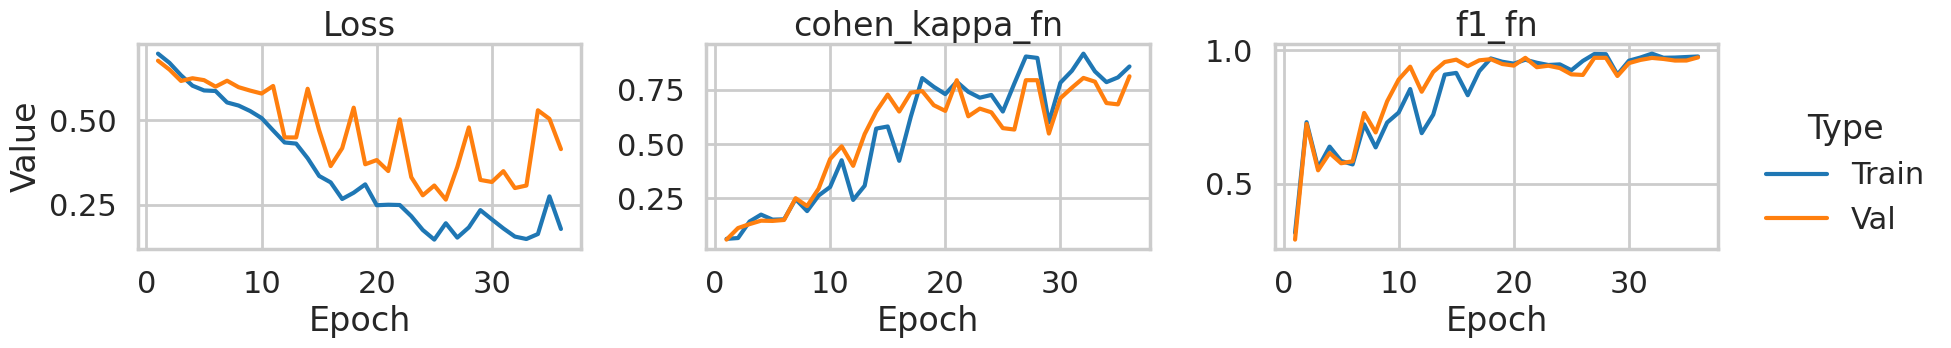

In [37]:
trainer_cnn_3.plot_epochs()

In [38]:
trainer_cnn_3.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2297 | Test cohen_kappa_fn: 0.6245 | Test f1_fn: 0.9213


#### Visualization

In [39]:
visualizer_3 = Visualizer(model=trainer_cnn_3.model, device=device, labels_map=labels_map)

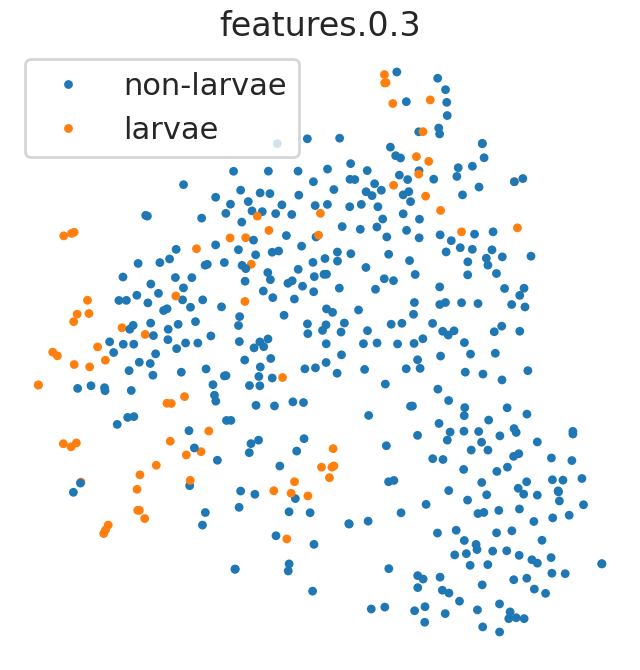

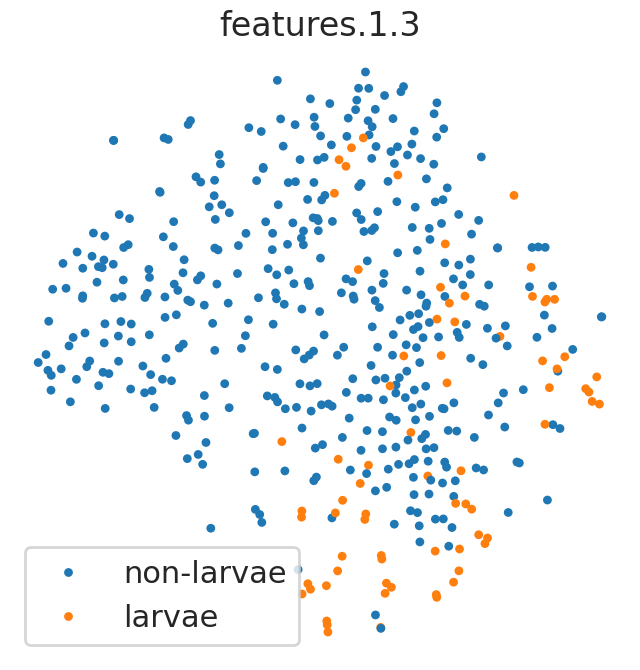

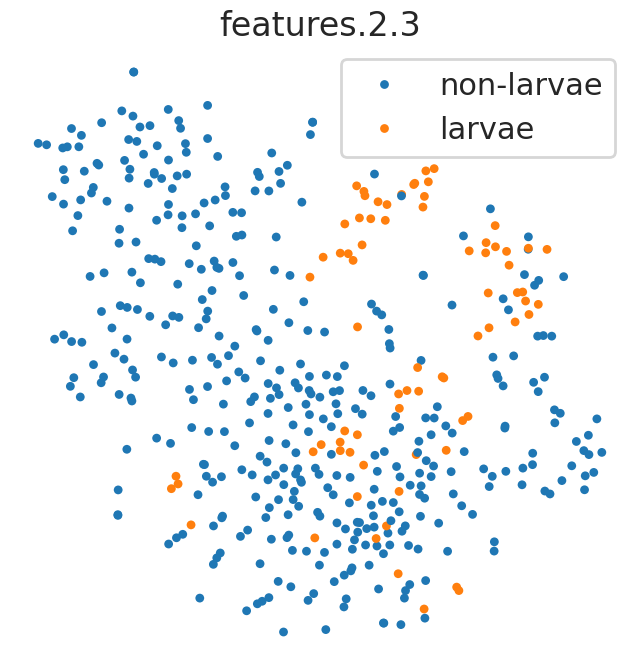

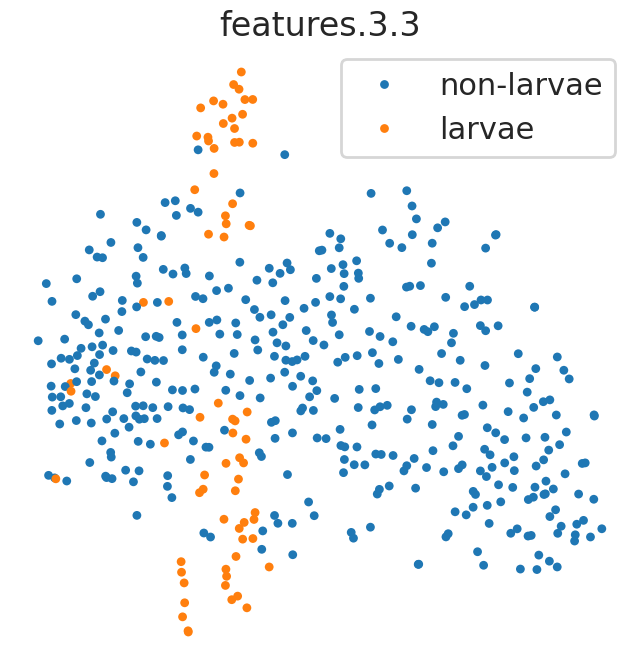

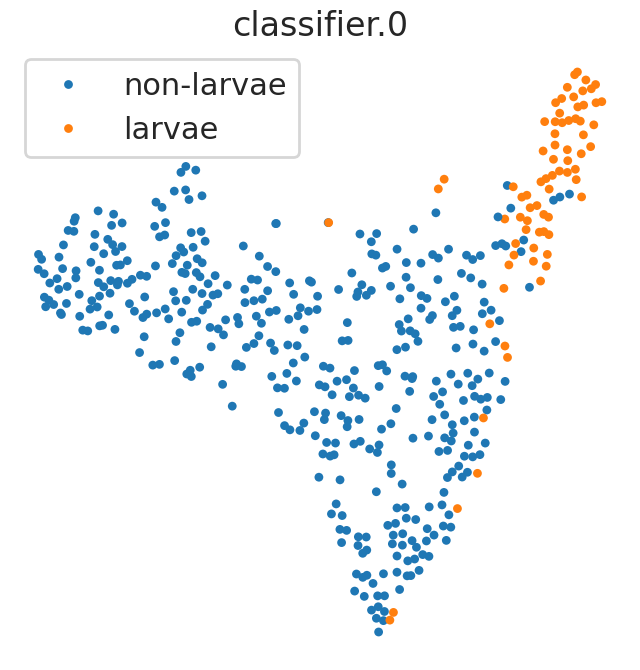

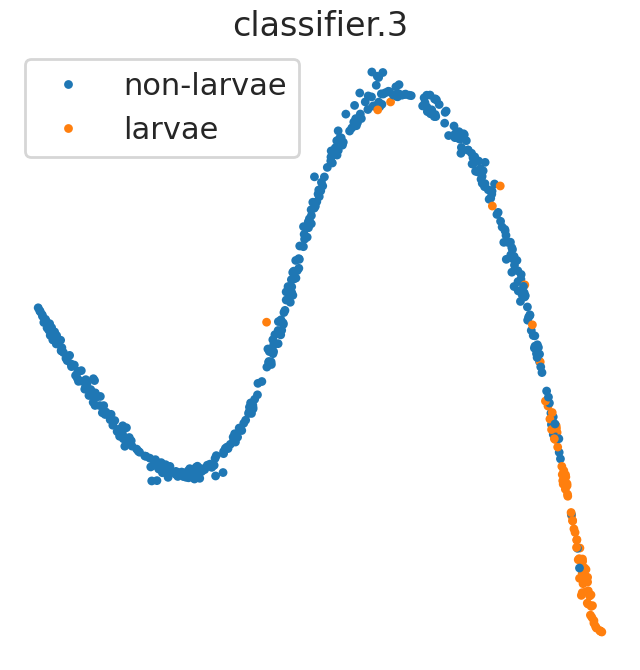

In [40]:
# Display layer representations
visualizer_3.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Larvae!


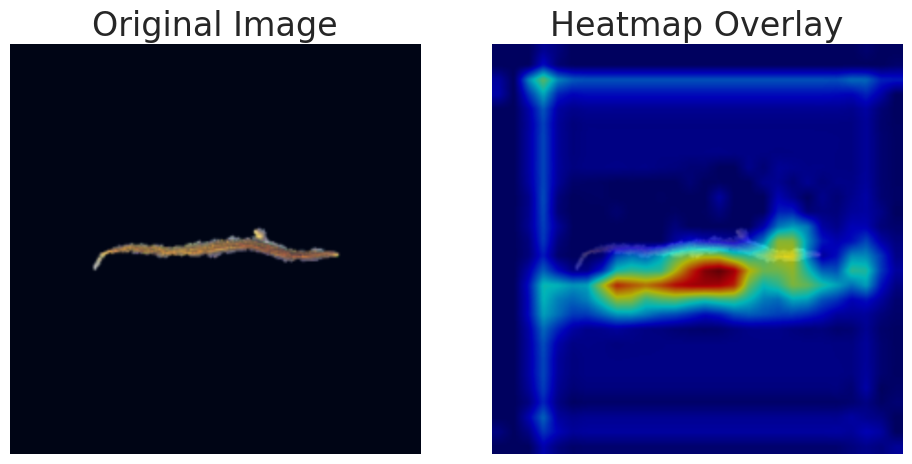

  Generating heatmap for Larvae...
  Predicted label is Larvae!


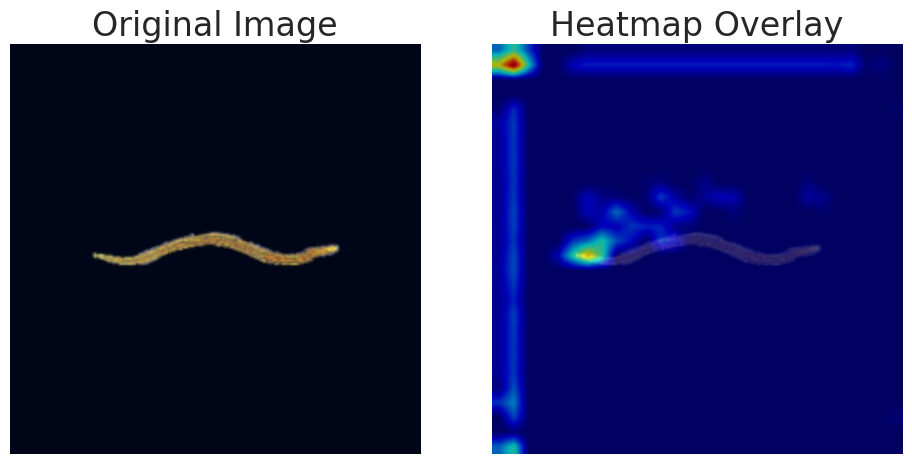

In [41]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break